In [21]:
%matplotlib inline

In [22]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as pp

# Generating Data

In [23]:
N = 10000

household_income = np.random.gamma(50, 1000, size=N)  # Z1, in USD. probably unrealistic, 
                                                      # since not long-tailed enough
parents_education = np.random.choice(range(5), size=N)  # Z2, labels ['no high school', high school', 'some college', 'BA/BS', 
                                                        #             'post-grad degree']
last_year_gpa = np.random.uniform(2.0, 4.0, size=N)  # Z3 on a 4-point scale, 
                                                     # assuming everyone passed last year
commute_time = np.random.gamma(1, 1, size=N)  # Z4, in hours
hobby_engagement = np.random.gamma(2, 1, size=N) # Z5, in hours per week

df = pd.DataFrame({'household_income': household_income,
                   'parents_education': parents_education,
                   'last_year_gpa': last_year_gpa,
                   'commute_time': commute_time,
                   'hobby_engagement': hobby_engagement})


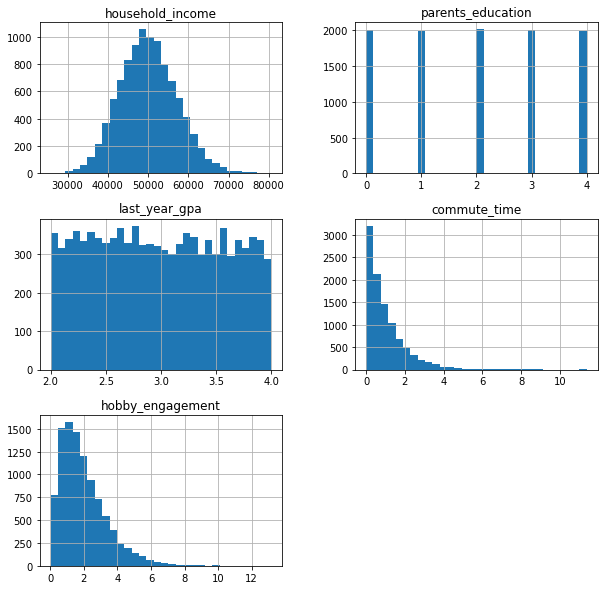

In [24]:
df.hist(figsize=(10,10), bins=30);

In [25]:
beta_ca = 1.
beta_ha = -1.
beta_ia = 1.
beta_ga = -1.
beta_ea = 1.
beta_a = -3

phi = beta_ca * df['commute_time'] / df['commute_time'].std() + \
      beta_ha * df['hobby_engagement'] / df['hobby_engagement'].std()+ \
      beta_ia * df['household_income'] / df['household_income'].std()+ \
      beta_ga * df['last_year_gpa'] / df['last_year_gpa'].std() + \
      beta_ea * df['parents_education'] / df['parents_education'].std() + \
      beta_a
p_app = 1. / (1. + np.exp(-phi))
df['uses_app'] = np.random.binomial(1., p=p_app)

In [26]:
df.mean()

household_income     50117.885999
parents_education        1.998400
last_year_gpa            2.985851
commute_time             1.004576
hobby_engagement         1.979906
uses_app                 0.482000
dtype: float64

In [27]:
df.corr()

,household_income,parents_education,last_year_gpa,commute_time,hobby_engagement,uses_app
household_income,1.000000,-0.004134,-0.000177,-0.011055,0.015526,0.264391
parents_education,-0.004134,1.000000,0.001118,-0.000511,0.005814,0.296272
last_year_gpa,-0.000177,0.001118,1.000000,0.008659,0.021770,-0.291929
commute_time,-0.011055,-0.000511,0.008659,1.000000,0.014354,0.263130
hobby_engagement,0.015526,0.005814,0.021770,0.014354,1.000000,-0.266162
uses_app,0.264391,0.296272,-0.291929,0.263130,-0.266162,1.000000


In [28]:
beta_cp = -1.
beta_hp = -1.
beta_ip = 1.
beta_gp = 8.
beta_p = -50
beta_ep = 1.

delta = 0.1

phi_p = beta_cp * df['commute_time'] / df['commute_time'].std() + \
        beta_hp * df['hobby_engagement'] / df['hobby_engagement'].std()+ \
        beta_ip * df['household_income'] / df['household_income'].std()+ \
        beta_gp * df['last_year_gpa'] / df['last_year_gpa'].std() + \
        beta_ep * df['parents_education'] / df['parents_education'].std() + \
        beta_p
p_passes = np.minimum(1. / (1. + np.exp(-phi_p/5)), 1. - delta - 0.001) + df['uses_app']*delta
df['passes'] = np.random.binomial(1., p=p_passes)

<AxesSubplot:>

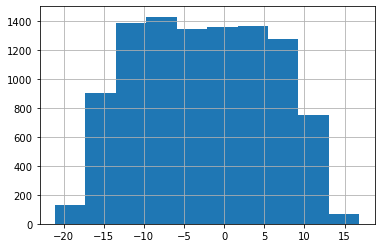

In [29]:
phi_p.hist()

In [30]:
df.mean()

household_income     50117.885999
parents_education        1.998400
last_year_gpa            2.985851
commute_time             1.004576
hobby_engagement         1.979906
uses_app                 0.482000
passes                   0.470300
dtype: float64

In [31]:
df.corr()

,household_income,parents_education,last_year_gpa,commute_time,hobby_engagement,uses_app,passes
household_income,1.000000,-0.004134,-0.000177,-0.011055,0.015526,0.264391,0.080164
parents_education,-0.004134,1.000000,0.001118,-0.000511,0.005814,0.296272,0.093662
last_year_gpa,-0.000177,0.001118,1.000000,0.008659,0.021770,-0.291929,0.538725
commute_time,-0.011055,-0.000511,0.008659,1.000000,0.014354,0.263130,-0.035908
hobby_engagement,0.015526,0.005814,0.021770,0.014354,1.000000,-0.266162,-0.064487
uses_app,0.264391,0.296272,-0.291929,0.263130,-0.266162,1.000000,-0.031214
passes,0.080164,0.093662,0.538725,-0.035908,-0.064487,-0.031214,1.000000


In [32]:
## Let's check the naive estimate

df.groupby('uses_app').mean()['passes'][1] - df.groupby('uses_app').mean()['passes'][0]

-0.031178807734824343

Looks like the effect is biased, from its true value of 0.1 percentage points.

Now, let's try exact matching. First, we should pre-process our continuous variables into discrete variables.

# NN Matching

## Performing Matching

In [33]:
matching_variables = ['household_income',
                      'parents_education',
                      'last_year_gpa',
                      'commute_time',
                      'hobby_engagement']

In [34]:
from sklearn.neighbors import NearestNeighbors

control_students = df[df.uses_app == 0]
test_students = df[df.uses_app == 1]

control_nn = NearestNeighbors(n_neighbors=1, 
                              metric='mahalanobis', 
                              metric_params={"V": control_students[matching_variables].cov()})
control_nn = control_nn.fit(control_students[matching_variables].values)
test_nn = NearestNeighbors(n_neighbors=1, 
                           metric='mahalanobis',
                           metric_params={"V": control_students[matching_variables].cov()})
test_nn = test_nn.fit(test_students[matching_variables].values)

In [35]:
def choose_match(row):
    if row['uses_app'] == 1:
        match_distances, match_indices = control_nn.kneighbors([row[matching_variables].values])
        matches = control_students.iloc[match_indices[0]]
    else:
        match_distances, match_indices = test_nn.kneighbors([row[matching_variables].values])
        matches = test_students.iloc[match_indices[0]]
    match = matches.sample(n=1)
    return match['passes'].values[0]

df['matched_outcome'] = df.apply(choose_match, axis=1)

In [36]:
y1 = df['uses_app']*df['passes'] + (1. - df['uses_app'])*df['matched_outcome']
y0 = (1-df['uses_app'])*df['passes'] + (df['uses_app'])*df['matched_outcome']
(y1 - y0).mean()

0.0853

In [37]:
att = df.groupby('uses_app').mean()['passes'][1] - df.groupby('uses_app').mean()['matched_outcome'][1]
att

0.08195020746887965

In [38]:
atc = df.groupby('uses_app').mean()['matched_outcome'][0] - df.groupby('uses_app').mean()['passes'][0]
atc

0.08841698841698842

In [39]:
p_x = df.mean()['uses_app']


In [40]:
p_x*att + (1 - p_x) * atc

0.08529999999999999

## Using a Caliper

In [41]:
from sklearn.neighbors import NearestNeighbors


control_students = df[df.uses_app == 0]
test_students = df[df.uses_app == 1]

control_nn = NearestNeighbors(n_neighbors=1, 
                              metric='mahalanobis', 
                              metric_params={"V": control_students[matching_variables].cov()})
control_nn = control_nn.fit(control_students[matching_variables].values)
test_nn = NearestNeighbors(n_neighbors=1, 
                           metric='mahalanobis',
                           metric_params={"V": control_students[matching_variables].cov()})
test_nn = test_nn.fit(test_students[matching_variables].values)

In [42]:
caliper = 1.

def choose_match(row):
    if row['uses_app'] == 1:
        match_distances, match_indices = control_nn.kneighbors([row[matching_variables].values])
        if match_distances[0] < caliper:
            matches = control_students.iloc[match_indices[0]]
        else:
            print('rejected: {} > {}'.format(match_distances[0], caliper))
            return np.nan
    else:
        match_distances, match_indices = test_nn.kneighbors([row[matching_variables].values])
        if match_distances[0] < caliper:
            matches = test_students.iloc[match_indices[0]]
        else:
            print('rejected: {} > {}'.format(match_distances[0], caliper))
            return np.nan
    match = matches.sample(n=1)
    return match['passes'].values[0]

df['matched_outcome'] = df.apply(choose_match, axis=1)

rejected: [3.86442119] > 1.0
rejected: [1.34849963] > 1.0
rejected: [1.1660966] > 1.0
rejected: [1.27294417] > 1.0
rejected: [1.06272643] > 1.0
rejected: [1.02528998] > 1.0
rejected: [1.11222564] > 1.0
rejected: [1.41752406] > 1.0
rejected: [1.01247753] > 1.0
rejected: [1.25880998] > 1.0
rejected: [1.88580735] > 1.0
rejected: [1.45821139] > 1.0
rejected: [1.4194615] > 1.0
rejected: [1.02868903] > 1.0
rejected: [1.02252535] > 1.0
rejected: [1.09277541] > 1.0
rejected: [1.22501119] > 1.0
rejected: [1.123878] > 1.0
rejected: [1.27772824] > 1.0
rejected: [1.17359014] > 1.0
rejected: [1.09760354] > 1.0
rejected: [2.4675331] > 1.0
rejected: [1.39900273] > 1.0
rejected: [1.2398614] > 1.0
rejected: [1.68387725] > 1.0
rejected: [1.12610639] > 1.0
rejected: [1.1626908] > 1.0
rejected: [1.12308232] > 1.0
rejected: [1.16501585] > 1.0
rejected: [1.34700582] > 1.0
rejected: [1.26136062] > 1.0
rejected: [1.01597806] > 1.0
rejected: [1.02389113] > 1.0
rejected: [1.26263823] > 1.0
rejected: [1.52614626

rejected: [1.25003988] > 1.0
rejected: [1.32294948] > 1.0
rejected: [1.33098751] > 1.0
rejected: [1.29268838] > 1.0
rejected: [1.26831687] > 1.0
rejected: [1.22398105] > 1.0
rejected: [1.17243406] > 1.0
rejected: [1.31241337] > 1.0
rejected: [1.06237803] > 1.0
rejected: [2.76333519] > 1.0
rejected: [2.71773728] > 1.0
rejected: [1.23188902] > 1.0
rejected: [1.23858879] > 1.0
rejected: [1.16886057] > 1.0
rejected: [2.34540142] > 1.0
rejected: [1.04912709] > 1.0
rejected: [1.2755405] > 1.0
rejected: [1.06378343] > 1.0
rejected: [1.43153685] > 1.0
rejected: [1.05800374] > 1.0
rejected: [1.09275948] > 1.0
rejected: [1.12419847] > 1.0
rejected: [1.05554853] > 1.0
rejected: [1.15802585] > 1.0
rejected: [1.59578945] > 1.0
rejected: [1.80522298] > 1.0
rejected: [1.01185416] > 1.0
rejected: [1.00494783] > 1.0
rejected: [1.23936258] > 1.0
rejected: [1.52411406] > 1.0
rejected: [2.16996384] > 1.0
rejected: [1.05226964] > 1.0
rejected: [1.25514249] > 1.0
rejected: [1.01295361] > 1.0
rejected: [1.12

rejected: [1.3653426] > 1.0
rejected: [1.23964243] > 1.0
rejected: [1.0705956] > 1.0
rejected: [4.19797587] > 1.0
rejected: [2.65961822] > 1.0
rejected: [1.75036026] > 1.0
rejected: [1.27968797] > 1.0
rejected: [1.62387313] > 1.0
rejected: [1.13282512] > 1.0
rejected: [1.18388489] > 1.0
rejected: [2.0649941] > 1.0
rejected: [1.71645506] > 1.0
rejected: [1.10630451] > 1.0
rejected: [1.15347518] > 1.0
rejected: [1.11462672] > 1.0
rejected: [1.28141683] > 1.0
rejected: [1.076595] > 1.0
rejected: [1.21974663] > 1.0
rejected: [1.54641217] > 1.0
rejected: [1.12025859] > 1.0
rejected: [1.00858275] > 1.0
rejected: [2.17234845] > 1.0
rejected: [1.40789994] > 1.0
rejected: [1.21432478] > 1.0
rejected: [1.09636417] > 1.0
rejected: [1.33935714] > 1.0
rejected: [1.85626562] > 1.0
rejected: [1.00341872] > 1.0
rejected: [2.25935619] > 1.0
rejected: [1.61274915] > 1.0
rejected: [1.2682463] > 1.0
rejected: [4.45910695] > 1.0
rejected: [1.09352182] > 1.0
rejected: [1.01248412] > 1.0
rejected: [2.0210414

rejected: [1.48040489] > 1.0
rejected: [1.39648461] > 1.0
rejected: [1.16060072] > 1.0
rejected: [1.15548179] > 1.0
rejected: [1.16568836] > 1.0
rejected: [1.44645317] > 1.0
rejected: [1.11649273] > 1.0
rejected: [1.58277053] > 1.0
rejected: [1.24721582] > 1.0
rejected: [1.16907612] > 1.0
rejected: [1.33812894] > 1.0
rejected: [1.20705165] > 1.0
rejected: [1.10450708] > 1.0
rejected: [1.84311791] > 1.0
rejected: [1.40527845] > 1.0
rejected: [1.04464297] > 1.0
rejected: [2.5326607] > 1.0
rejected: [1.75419478] > 1.0
rejected: [1.049741] > 1.0
rejected: [1.44743592] > 1.0
rejected: [1.13688849] > 1.0
rejected: [1.72542247] > 1.0
rejected: [1.24285208] > 1.0
rejected: [1.11363644] > 1.0
rejected: [1.42655422] > 1.0
rejected: [1.00274295] > 1.0
rejected: [1.01480392] > 1.0
rejected: [1.78580068] > 1.0
rejected: [1.17366944] > 1.0
rejected: [1.15077721] > 1.0
rejected: [1.40740149] > 1.0
rejected: [1.32959523] > 1.0
rejected: [1.50905737] > 1.0
rejected: [1.59875921] > 1.0
rejected: [1.4926

In [43]:
y1 = df['uses_app']*df['passes'] + (1. - df['uses_app'])*df['matched_outcome']
y0 = (1-df['uses_app'])*df['passes'] + (df['uses_app'])*df['matched_outcome']
(y1 - y0).mean()

0.10129431626336523